Tensor Network Random Unitary Evolution
======================

This example demonstrates some features of ``TensorNetwork`` manipulation as well as the use of ``MatrixProductState.gate``, based on 'evolving' an intitial MPS with many random nearest neighbour unitaries.

In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
from quimb.tensor import *
from quimb import *
import numpy as np

First we specify how sites we want, how many gates to apply, and some other parameters:

In [3]:
# the initial state
n = 50
cyclic = False
chi = 4  # intial bond dimension
psi = MPS_rand_state(n, chi, cyclic=cyclic, tags='KET', dtype='complex128')

# the gates
n_gates = 5 * n
gates = [rand_uni(4) for _ in range(n_gates)]
u_tags = [f'U{i}' for i in range(n_gates)]

We generate a unique tag for each gate we will apply, which we can also use to address all the gates only.

Then we apply each gate to the MPS inplace:

In [4]:
for U, t in zip(gates, u_tags):
    # generate a random coordinate
    i = np.random.randint(0, n - int(not cyclic))
    
    # apply the next gate to the coordinate
    #     propagate_tags='sites' (the default in fact) specifies that the
    #     new gate tensor should inherit the site tags from tensors it acts on
    psi.gate_(U, where=[i, i + 1], tags=t, propagate_tags='sites')

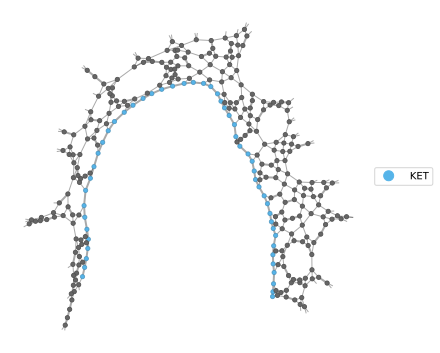

In [5]:
psi.draw(color=['KET'])

To make the graph a bit neater we can supply some fixed positions:

In [6]:
fix = {
    # [key - tags that uniquely locate a tensor]: [val - (x, y) coord]
    **{('KET', f'I{i}'): (i, +10) for i in range(n)},
    # can also use a external index, 'k0' etc, as a key to fix it
    **{f'k{i}': (i, -10) for i in range(n)},
}

When fixing graphs, it might also be necessary to play with the spring parameter ``k``:

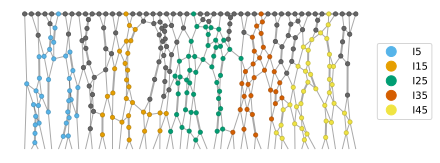

In [7]:
psi.draw(fix=fix, k=0.001, color=['I5', 'I15', 'I25', 'I35', 'I45'])

We can see the 'lightcone' effect of adding ``propagate_tags='sites``.

Next let's form the norm overlap, and add one tag to all the gates, and another to all the non-gate tensors:

In [8]:
psiH = psi.H
psiH.retag_({'KET': 'BRA'})  # specify this to distinguish 

norm = (psiH | psi)
norm.add_tag('UGs', where=u_tags, which='any')
norm.add_tag('VEC0', where=u_tags, which='!any')

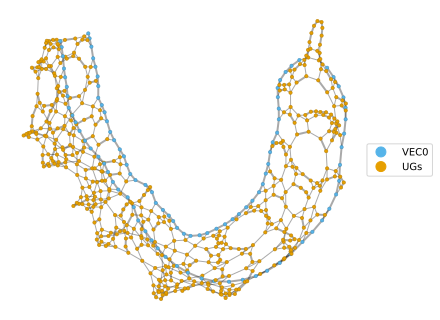

In [9]:
norm.draw(color=['VEC0', 'UGs'])

Again, it's a bit messy so we can specify some positions for some tensors:

In [10]:
fix = {
    **{(f'I{i}', 'KET', 'VEC0'): (i, -20) for i in range(n)},
    **{(f'I{i}', 'BRA', 'VEC0'): (i, +20) for i in range(n)},
}

``iterations`` can also be increased if the graph is not relaxing well.

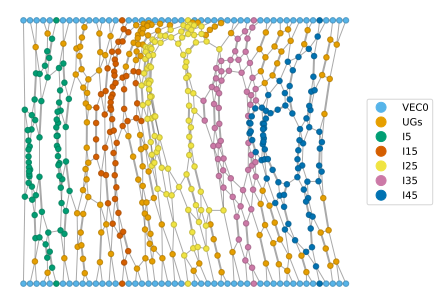

In [11]:
(psiH | psi).draw(
    color=['VEC0', 'UGs', 'I5', 'I15', 'I25', 'I35', 'I45'], 
    node_size=30, 
    iterations=500,
    fix=fix, k=0.0001)

Later ``color`` tags take precedence over earlier ones.

Since this circuit is still relatively low depth, we can fully contract it as well:

In [12]:
# this calculates an opimized path for the contraction, which is cached 
#     the path can also be inspected with `print(expr)`
expr = (psi.H | psi).contract(all, get='path-info')

In [13]:
%%time
(psi.H | psi) ^ all

CPU times: user 182 ms, sys: 8.08 ms, total: 190 ms
Wall time: 116 ms


(0.9999999999999871+5.204170427930421e-18j)

Manually perform partial trace
----------------------------------

Here, to perform the partial trace we need to do two things. (i) Make a copy of the vector to be the 'bra' with different indices, (ii) match up the subsystem indices we want to trace out in the 'ket' and 'bra':

In [14]:
# make a 'bra' vector copy with 'upper' indices
psiH = psi.H
psiH.retag_({'KET': 'BRA'})
# this automatically reindexes the TN
psiH.site_ind_id = 'b{}'

# define two subsystems
sysa = range(15, 35)
sysb = [i for i in range(n) if i not in sysa]

# join indices for sysb only
psi.reindex_sites('dummy_ptr{}', sysb, inplace=True)
psiH.reindex_sites('dummy_ptr{}', sysb, inplace=True)

rho_ab = (psiH | psi)
rho_ab

<TensorNetwork(tensors=600, indices=1168, structure='I{}', nsites=50)>

In [15]:
fix = {
    **{f'k{i}': (i, -10) for i in range(n)},
    **{(f'I{i}', 'KET', 'VEC0'): (i, 0) for i in range(n)},
    **{(f'I{i}', 'BRA', 'VEC0'): (i, 10) for i in range(n)},
    **{f'b{i}': (i, 20) for i in range(n)},
}

Again we can graph this:

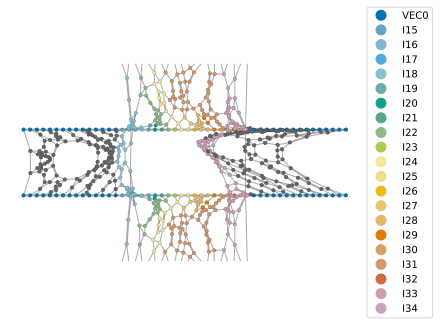

In [16]:
rho_ab.draw(color=['VEC0'] + [f'I{i}' for i in sysa], iterations=500, fix=fix, k=0.001)

Estimate Subsystem Entropy
------------------------------

We can treat this whole reduced density matrix as an effective linear operator, $A$, then calculate for example its entropy as a spectral sum function, $-\text{Tr}(A \log_2 A)$. First we set the left and right indices, and turn it into a ``scipy.sparse.linalg.LinearOperator``:

In [17]:
right_ix = [f'b{i}' for i in sysa]
left_ix = [f'k{i}' for i in sysa]

rho_ab_lo = rho_ab.aslinearoperator(left_ix, right_ix, backend='cupy')
rho_ab_lo

<1048576x1048576 TNLinearOperator with dtype=complex128>

This can be quite slow, so wise to check progress:

In [18]:
S_a = - approx_spectral_function(rho_ab_lo, f=xlogx, verbosity=1, R=10)

LANCZOS f(A) CALC: tol=0.01, tau=0.0001, R=10, bsz=1
k=57: Returning estimate -5.480053227733483.
Repeat 1: estimate is -5.480053227733483
k=48: Returning estimate -4.987340728705768.
Repeat 2: estimate is -4.987340728705768
k=42: Returning estimate -6.551967475397945.
Repeat 3: estimate is -6.551967475397945
Total estimate = -5.673120477279066 ± 0.3771149062292873
k=48: Returning estimate -6.368435763357799.
Repeat 4: estimate is -6.368435763357799
Total estimate = -5.846949298798749 ± 0.3204038840660703
k=44: Returning estimate -6.689604577557199.
Repeat 5: estimate is -6.689604577557199
Total estimate = -6.015480354550439 ± 0.2973612427906209
k=57: Returning estimate -4.993761544626728.
Repeat 6: estimate is -4.993761544626728
Total estimate = -5.845193886229819 ± 0.2925233683278253
k=51: Returning estimate -5.3493674304000605.
Repeat 7: estimate is -5.3493674304000605
Total estimate = -5.774361535396997 ± 0.2591682330256407
k=48: Returning estimate -7.03548223683227.
Repeat 8: esti

Which yields the final entropy (in bits) of the central 20 qubits as:

In [19]:
S_a

5.762792537786092

Since ``TNLinearOperator`` repeatedly calls the same effective matrix-vector tensor contraction and does not require high precision this kind of computation is also ideally suited to being compiled into a GPU expression using ``tensorflow`` for example.